In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [83]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
device = 'cuda'

In [84]:
# Import dataset from
# https://www.kaggle.com/datasets/mehmetcalikus/turkish-emotion-dataset
# https://www.kaggle.com/datasets/mansuralp/tremo
train = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/turkish-emotion-analysis/Emotion_dataset_train.csv',index_col=False)
train.rename(columns={'Sentence':'text','Label':'label'},inplace=True)
train.drop(['Unnamed: 0'],inplace=True,axis='columns')

test = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/turkish-emotion-analysis/Emotion_dataset_test.csv',index_col=False)
test.rename(columns={'Sentence':'text','Label':'label'},inplace=True)
test.drop(['Unnamed: 0'],inplace=True,axis='columns')

tremodata = pd.read_xml('/content/drive/MyDrive/sentiment_analysis/turkish-emotion-analysis/TREMODATA.xml')
tremodata = tremodata[tremodata['Condition'] == 'Consensus']
tremodata.drop(['ID','OriginalEmotion','Condition','VoteDistribution'],axis='columns',inplace=True)
tremodata.rename(columns={'Entry':'text', 'ValidatedEmotion':'label'},inplace=True)
tremodata = tremodata.reset_index(drop=True)

frames = [train, test, tremodata]
df = pd.concat(frames)
df = df.reset_index(drop=True)

In [85]:
# Labeling concatenated dataframe
for i in df.index:
  if df.label.iloc[i] == 'surpriz' or df.label.iloc[i] == 'Surprise':
    df.at[i, 'label'] = 'surprise'
  elif df.label.iloc[i] == 'kızgın' or df.label.iloc[i] == 'Anger':
    df.at[i, 'label'] = 'anger'
  elif df.label.iloc[i] == 'Happy' or df.label.iloc[i] == 'mutlu':
    df.at[i, 'label'] = 'joy'
  elif df.label.iloc[i] == 'üzgün' or df.label.iloc[i] == 'Sadness':
    df.at[i, 'label'] = 'sadness'
  elif df.label.iloc[i] == 'korku' or df.label.iloc[i] == 'Fear':
    df.at[i, 'label'] = 'fear'
  elif df.label.iloc[i] == 'Disgust':
    df.at[i, 'label'] = 'disgust'

In [86]:
df.label.unique()

array(['anger', 'surprise', 'joy', 'sadness', 'fear', 'disgust'],
      dtype=object)

In [87]:
# Preprocess text
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word == 'RT':
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        elif word.startswith('!') or word.startswith('&') or word.startswith('-'):
            continue
        else:
            final_text += word+' '
    return final_text

df['text'] = df['text'].apply(filter)
df

,text,label
0,Allah aşkına bi fırça neden 250 tl neden yani ...,anger
1,Muavin bir şey içip içmediğimi sormak için ben...,surprise
2,Herkese güzel günler öpüyorum sizler tivitır a...,joy
3,Ya şu sevgililerin birbirine şifre verme olayı...,anger
4,Almanya'da 'yok artık' dedirten olay! Nereye p...,surprise
...,...,...
23457,Okuldan mezun olduğum an.,joy
23458,Biri bana bir işi nasıl yapmam gerektiğini söy...,anger
23459,Park halindeki arabama çarptıklarında.,anger
23460,Bardağımı başkasının kullanması.,disgust


In [88]:
df[df.label==5]

,text,label


In [89]:
# Converting labels to numerical
# 'anger'==0, 'surprise'==1, 'joy'==2, 'sadness'==3, 'fear'==4, 'disgust==5'
for i in df.index:
    if df.label.iloc[i] == 'anger':
      df.at[i, 'label'] = 0
    elif df.label.iloc[i] == 'surprise':
      df.at[i, 'label'] = 1
    elif df.label.iloc[i] == 'joy':
      df.at[i, 'label'] = 2
    elif df.label.iloc[i] == 'sadness':
      df.at[i, 'label'] = 3
    elif df.label.iloc[i] == 'fear':
      df.at[i, 'label'] = 4
    else:
      df.at[i, 'label'] = 5

<Axes: >

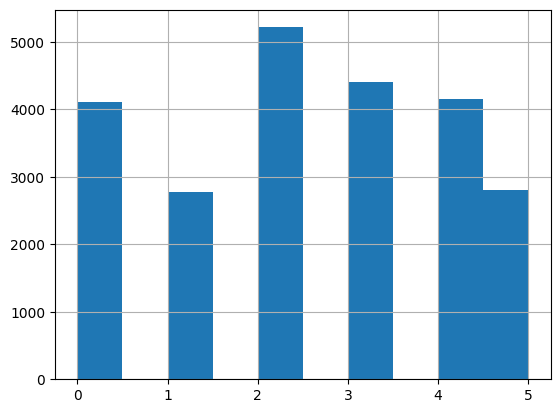

In [90]:
# Distribution of labels
df.label.hist()

In [91]:
# Shuffle dataset
from sklearn.utils import shuffle
df = shuffle(df)

In [92]:
# Split data into train, test, valid
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
																	random_state = 2021,
																	test_size = 0.2,
																	stratify = df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
																random_state = 2021,
																test_size = 0.5,
																stratify = temp_labels)

In [93]:
# Import pretrained tokenizer and model from https://huggingface.co/maymuni/bert-base-turkish-cased-emotion-analysis?text=I+like+you.+I+love+you
tokenizer = AutoTokenizer.from_pretrained("maymuni/bert-base-turkish-cased-emotion-analysis")
bert = AutoModel.from_pretrained("maymuni/bert-base-turkish-cased-emotion-analysis",return_dict=False)

Some weights of the model checkpoint at maymuni/bert-base-turkish-cased-emotion-analysis were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [95]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [96]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze Model Params and Define Architecture

In [97]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [98]:
class Arch(nn.Module):

    def __init__(self, bert):
      
      super(Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(512,6)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [99]:
# pass the pre-trained model to our define architecture
model = Arch(bert)

# push the model to GPU
model = model.to(device)

In [100]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.0001)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [101]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.95196794 1.40654976 0.74962058 0.8864173  0.94250276 1.39775097]


In [102]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 7

### Fine-tuning

In [103]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [104]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [105]:
# Define Early Stopping Function
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

### Start Training

In [106]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train the model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/turkish_emotion_analysis.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping
    if early_stopping(train_loss, valid_loss, min_delta=10, tolerance = 20):
      print("We are at epoch:", epoch)
      break


 Epoch 1 / 7
  Batch    50  of    587.
  Batch   100  of    587.
  Batch   150  of    587.
  Batch   200  of    587.
  Batch   250  of    587.
  Batch   300  of    587.
  Batch   350  of    587.
  Batch   400  of    587.
  Batch   450  of    587.
  Batch   500  of    587.
  Batch   550  of    587.

Evaluating...
  Batch    50  of     74.

Training Loss: 0.459
Validation Loss: 0.356

 Epoch 2 / 7
  Batch    50  of    587.
  Batch   100  of    587.
  Batch   150  of    587.
  Batch   200  of    587.
  Batch   250  of    587.
  Batch   300  of    587.
  Batch   350  of    587.
  Batch   400  of    587.
  Batch   450  of    587.
  Batch   500  of    587.
  Batch   550  of    587.

Evaluating...
  Batch    50  of     74.

Training Loss: 0.341
Validation Loss: 0.309

 Epoch 3 / 7
  Batch    50  of    587.
  Batch   100  of    587.
  Batch   150  of    587.
  Batch   200  of    587.
  Batch   250  of    587.
  Batch   300  of    587.
  Batch   350  of    587.
  Batch   400  of    587.
  Batc

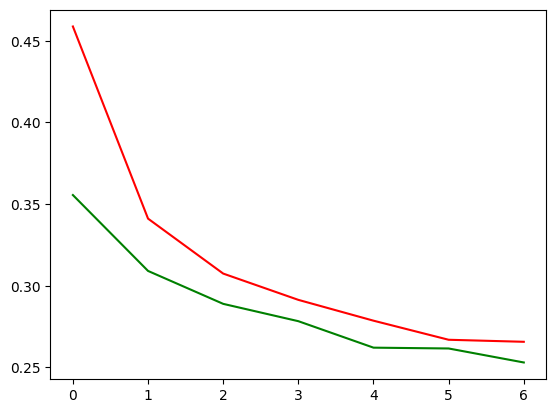

In [107]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r')
plt.plot(valid_losses, color='g')

### Evaluation

In [108]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# Labeling
predicted_label = []
for pred in preds:
  predicted_label.append(np.argmax(pred))

In [109]:
from sklearn.metrics import classification_report
target_names = ['anger', 'surprise', 'joy', 'sadness', 'fear', 'disgust']
print(classification_report(test_y, predicted_label, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.91      0.92      0.91       410
    surprise       0.90      0.95      0.93       278
         joy       0.91      0.93      0.92       522
     sadness       0.92      0.90      0.91       442
        fear       0.93      0.90      0.92       415
     disgust       0.94      0.92      0.93       280

    accuracy                           0.92      2347
   macro avg       0.92      0.92      0.92      2347
weighted avg       0.92      0.92      0.92      2347



In [110]:
# confusion matrix
pd.crosstab(test_y, predicted_label)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,377,5,10,8,4,6
1,1,265,7,1,4,0
2,6,14,484,10,7,1
3,18,3,15,397,7,2
4,4,2,13,14,375,7
5,9,5,3,1,5,257


In [111]:
# Define predict function
def predict_emotion(text):
  tokenized = tokenizer.encode_plus(
    text,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']

  seq = torch.tensor(input_ids)
  mask = torch.tensor(attention_mask)
  seq = seq.unsqueeze(0)
  mask = mask.unsqueeze(0)
  preds = model(seq.to(device), mask.to(device))
  preds = preds.detach().cpu().numpy()
  result = np.argmax(preds, axis=1)
  preds = torch.tensor(preds)
  probabilities = nn.functional.softmax(preds)

  return {'anger':float(probabilities[0][0]),
          'surprise':float(probabilities[0][1]),
          'joy':float(probabilities[0][2]),
          'sadness':float(probabilities[0][3]),
          'fear':float(probabilities[0][4]),
          'disgust':float(probabilities[0][5])
          }

In [112]:
predict_emotion('Gece karanlıkta fazla dolaşmayın.')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-111-a025fa522e87>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


{'anger': 0.005498265381902456,
 'surprise': 0.0010965547990053892,
 'joy': 0.0027137119323015213,
 'sadness': 0.0010590101592242718,
 'fear': 0.9840105175971985,
 'disgust': 0.005622046533972025}